# Mahalanobis outlier detection on KDD Cup '99 dataset

## Method

The Mahalanobis online outlier detector aims to predict anomalies in tabular data. The algorithm calculates an outlier score, which is a measure of distance from the center of the features distribution ([Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)). If this outlier score is higher than a user-defined threshold, the observation is flagged as an outlier. The algorithm is online, which means that it starts without knowledge about the distribution of the features and learns as requests arrive. Consequently you should expect the output to be bad at the start and to improve over time.

## Dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [2]:
!pip install seaborn

You should consider upgrading via the 'C:\Users\sanje\miniconda3\envs\drift\python.exe -m pip install --upgrade pip' command.


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from alibi_detect.od import Mahalanobis
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.mapping import ord2ohe
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [4]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a machine learning model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [5]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=100000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(100000, 18) (100000,)
0.0% outliers


In [6]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

## Load or define outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can initialise a detector from scratch. 

Be aware that `Mahalanobis` is an online, stateful outlier detector. Saving or loading a Mahalanobis detector therefore also saves and loads the state of the detector. This allows the user to *warm up* the detector before deploying it into production.

In [7]:
load_outlier_detector = False

In [9]:
filepath = 'my_path'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'kddcup'
detector_name = 'Mahalanobis'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load initialized outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # initialize and save outlier detector
    threshold = None  # scores above threshold are classified as outliers   
    n_components = 2  # nb of components used in PCA
    std_clip = 3  # clip values used to compute mean and cov above "std_clip" standard deviations
    start_clip = 20  # start clipping values after "start_clip" instances
    
    od = Mahalanobis(threshold, 
                     n_components=n_components,
                     std_clip=std_clip,
                     start_clip=start_clip)
    
    save_detector(od, filepath)  # save outlier detector

No threshold level set. Need to infer threshold using `infer_threshold`.


If `load_outlier_detector` equals False, the warning tells us we still need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have some data which we know contains around 5% outliers. The percentage of outliers can be set with `perc_outlier` in the `create_outlier_batch` function.

In [14]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [15]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))
threshold = od.threshold

New threshold: 1.078327400343442


## Detect outliers

We now generate a batch of data with 10% outliers, standardize those with the `mean` and `stdev` values obtained from the normal data (*inliers*) and detect the outliers in the batch. 

In [16]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [17]:
od_preds = od.predict(X_outlier, return_instance_score=True)

We can now save the *warmed up* outlier detector:

In [18]:
save_detector(od, filepath)

## Display results

F1 score and confusion matrix:

F1 score: 0.9405940594059405


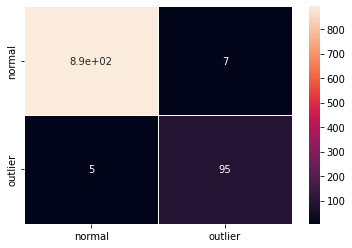

In [19]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

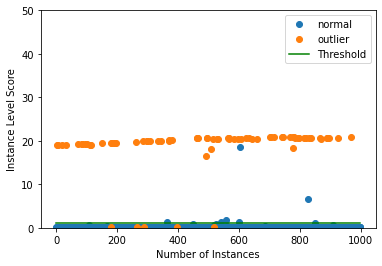

In [20]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold, ylim=(0,50))

We can also plot the ROC curve for the outlier scores of the detector:

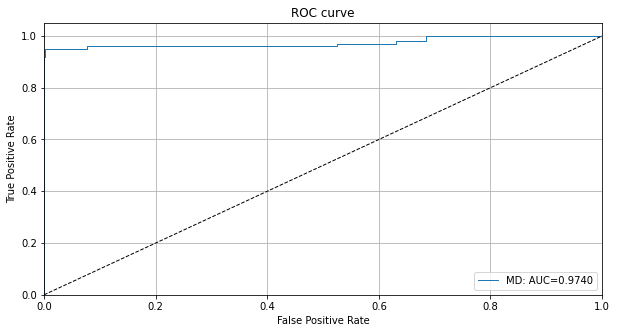

In [21]:
roc_data = {'MD': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)

## Include categorical variables

So far we only tracked continuous variables. We can however also include categorical variables. The `fit` step first computes pairwise distances between the categories of each categorical variable. The pairwise distances are based on either the model predictions (*MVDM method*) or the context provided by the other variables in the dataset (*ABDM method*). For MVDM, we use the difference between the conditional model prediction probabilities of each category. This method is based on the Modified Value Difference Metric (MVDM) by [Cost et al (1993)](https://link.springer.com/article/10.1023/A:1022664626993). ABDM stands for Association-Based Distance Metric, a categorical distance measure introduced by [Le et al (2005)](http://www.jaist.ac.jp/~bao/papers/N26.pdf). ABDM infers context from the presence of other variables in the data and computes a dissimilarity measure based on the Kullback-Leibler divergence. Both methods can also be combined as ABDM-MVDM. We can then apply multidimensional scaling to project the pairwise distances into Euclidean space.

### Load and transform data

In [22]:
cat_cols = ['protocol_type', 'service', 'flag']
num_cols = ['srv_count', 'serror_rate', 'srv_serror_rate',
            'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
            'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
            'dst_host_srv_count', 'dst_host_same_srv_rate', 
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
            'dst_host_srv_rerror_rate']
cols = cat_cols + num_cols

In [24]:
np.random.seed(0)
kddcup = fetch_kdd(keep_cols=cols, percent10=True)
print(kddcup.data.shape, kddcup.target.shape)

(494021, 21) (494021,)


Create a dictionary with as keys the categorical columns and values the number of categories for each variable in the dataset. This dictionary will later be used in the `fit` step of the outlier detector.

In [30]:
cat_vars_ord = {}
n_categories = len(cat_cols)
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(kddcup.data[:, i]))
print(cat_vars_ord)

{0: 3, 1: 66, 2: 11}


Fit an ordinal encoder on the categorical data:

In [31]:
enc = OrdinalEncoder()
enc.fit(kddcup.data[:, :n_categories])

OrdinalEncoder()

Combine scaled numerical and ordinal features. `X_fit` will be used to infer distances between categorical features later. To make it easy, we will already transform the whole dataset, including the outliers that need to be detected later. This is for illustrative purposes:

In [32]:
X_num = (kddcup.data[:, n_categories:] - mean) / stdev  # standardize numerical features
X_ord = enc.transform(kddcup.data[:, :n_categories])  # apply ordinal encoding to categorical features
X_fit = np.c_[X_ord, X_num].astype(np.float32, copy=False)  # combine numerical and categorical features
print(X_fit.shape)

(494021, 21)


### Initialize and fit outlier detector

We use the same threshold as for the continuous data. This will likely not result in optimal performance. Alternatively, you can infer the threshold again.

In [33]:
n_components = 2
std_clip = 3
start_clip = 20
    
od = Mahalanobis(threshold,
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip,
                 cat_vars=cat_vars_ord,
                 ohe=False)  # True if one-hot encoding (OHE) is used

Set `fit` parameters:

In [38]:
d_type = 'abdm'  # pairwise distance type, 'abdm' infers context from other variables
disc_perc = [25, 50, 75]  # percentiles used to bin numerical values; used in 'abdm' calculations
standardize_cat_vars = True  # standardize numerical values of categorical variables

Apply `fit` method to find numerical values for categorical variables:

In [35]:
od.fit(X_fit,
       d_type=d_type,
       disc_perc=disc_perc,
       standardize_cat_vars=standardize_cat_vars)

The numerical values for the categorical features are stored in the attribute `od.d_abs`. This is a dictionary with as keys the columns for the categorical features and as values the numerical equivalent of the category:

In [39]:
cat = 0  # categorical variable to plot numerical values for

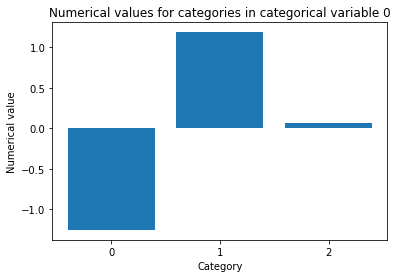

In [40]:
plt.bar(np.arange(len(od.d_abs[cat])), od.d_abs[cat])
plt.xticks(np.arange(len(od.d_abs[cat])))
plt.title('Numerical values for categories in categorical variable {}'.format(cat))
plt.xlabel('Category')
plt.ylabel('Numerical value')
plt.show()

Another option would be to set `d_type` to `'mvdm'` and `y` to `kddcup.target` to infer the numerical values for categorical variables from the model labels (or alternatively the predictions).

### Run outlier detector and display results

Generate batch of data with 10% outliers:

In [41]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
data, y_outlier = outlier_batch.data, outlier_batch.target
print(data.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 21) (1000,)
10.0% outliers


Preprocess the outlier batch:

In [42]:
X_num = (data[:, n_categories:] - mean) / stdev
X_ord = enc.transform(data[:, :n_categories])
X_outlier = np.c_[X_ord, X_num].astype(np.float32, copy=False)
print(X_outlier.shape)

(1000, 21)


Predict outliers:

In [43]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score and confusion matrix:

F1 score: 0.9494949494949495


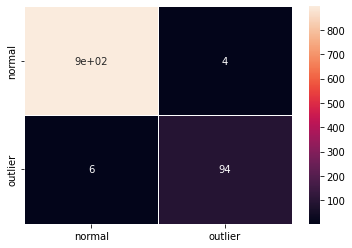

In [44]:
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

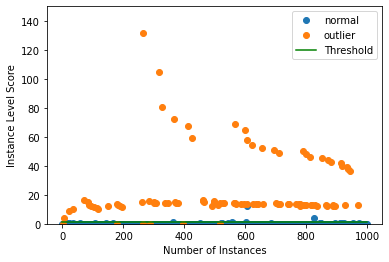

In [45]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold, ylim=(0, 150))

## Use OHE instead of ordinal encoding for the categorical variables

Since we will apply one-hot encoding (OHE) on the categorical variables, we convert `cat_vars_ord` from the ordinal to OHE format. `alibi_detect.utils.mapping` contains utility functions to do this. The keys in `cat_vars_ohe` now represent the first column index for each one-hot encoded categorical variable. This dictionary will later be used in the counterfactual explanation.

In [46]:
cat_vars_ohe = ord2ohe(X_fit, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 3, 3: 66, 69: 11}


Fit a one-hot encoder on the categorical data:

In [47]:
enc = OneHotEncoder(categories='auto')
enc.fit(X_fit[:, :n_categories])

OneHotEncoder()

Transform `X_fit` to OHE:

In [48]:
X_ohe = enc.transform(X_fit[:, :n_categories])
X_fit = np.array(np.c_[X_ohe.todense(), X_fit[:, n_categories:]].astype(np.float32, copy=False))
print(X_fit.shape)

(494021, 98)


### Initialize and fit outlier detector

Initialize:

In [49]:
od = Mahalanobis(threshold,
                 n_components=n_components, 
                 std_clip=std_clip, 
                 start_clip=start_clip,
                 cat_vars=cat_vars_ohe,
                 ohe=True)

Apply fit method:

In [34]:
od.fit(X_fit,
       d_type=d_type,
       disc_perc=disc_perc,
       standardize_cat_vars=standardize_cat_vars)

### Run outlier detector and display results

Transform outlier batch to OHE:

In [35]:
X_ohe = enc.transform(X_ord)
X_outlier = np.array(np.c_[X_ohe.todense(), X_num].astype(np.float32, copy=False))
print(X_outlier.shape)

(1000, 98)


Predict outliers:

In [36]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score and confusion matrix:

F1 score: 0.9375


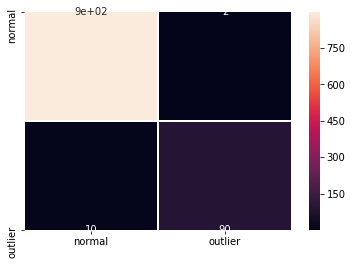

In [37]:
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

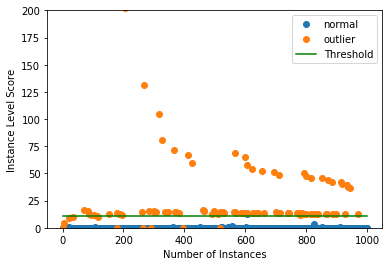

In [38]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold, ylim=(0,200))